# Importing and Configs


## Importing

Running the code cell below installs all the necessary dependencies and libraries to run the code within this notebook.

It also loads the data into the notebook with the assumption that the SRET2019.csv file is in your Google Drive under MyDrive (it should just be the main directory of your Google Drive).

Reminder that the data is of the shape **2736 x 20**. That is **57** participants and **48** conditions, with 20 different pieces of information about the participant in the experiment **(57x48)rows x 20columns**.

In [1]:
# Necessary imports
!pip install pyddm
import sys
import os
from contextlib import redirect_stdout
import pandas as pd
import numpy as np
import warnings
import logging
import seaborn as sns
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
from google.colab import drive
from pyddm import Model, Sample, Fittable, fit_adjust_model
from pyddm.models import Drift, DriftConstant, BoundConstant, NoiseConstant, OverlayNonDecision, ICUniform, OverlayChain, OverlayUniformMixture
from pyddm.models.loss import LossRobustLikelihood

drive.mount('/content/drive')

# Path to lthe data
file_path = '/content/drive/MyDrive/SRET2019.csv'

# Read the CSV file
data = pd.read_csv(file_path)

# Datashape is such that there are 2736 rows and 20 columns. The rows are 57 participants x 48 conditions.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Configs

The configurations specified below present the thresholds for each of the clinical assessments taken by the participants in efforts to characterise their depression and anxiety.

These thresholds are specified here for the sake of being able to edit them if necessary.

I also specify the column names of the dataset which I want to keep, as well as the words mentioned in the paper that are separated into high affliation, low affiliation, high dominance and low dominance.

In [2]:
# Configs for the classification of anxious and depressed thresholds
anxiety_threshold = {'LSAS': 55, 'SPIN': 25, 'BFNE':30, 'STAI-S':40 , 'STAI-T':30}
depression_threshold = {'BDI': 12, 'RSES': 14, 'FPES': 25}

# Configs for the columns left after the cleaning
col_names = ['Subject','Circumplex','Valence','Response','SERT.RT','taskword','Recall','anxiety','depression']

# Configs for the words in each category
high_aff = ['kind', 'empathic', 'good-hearted','considerate','nice','pleasant','tolerant','supportive','helpful','attentive','listener']
low_aff = ['egoistic','apathetic','disconnected','distant','nasty','loner','cold','impervious','sarcastic','alienated','aloof']
high_dom = ['assertive','prominent','proud','dominant','decisive','strong','charistmatic','impervious','successful','influential','authoratitive']
low_dom = ['passive','loser','submissive','ridiculous','pathetic','lame','coward','humiliated','inferior','no one','easily affected']



## Participant classification

Below is a code cell which runs over the data, and, based on the thresholds of the clinical assessments and then further averaging between them, the participants are classed in binary terms as depressed (1 if yes, 0 if not) or anxious (1 if yes, 0 if not).

This is to ease the mathematical segregation, however it is acknowledged that this lowers the granularity of each participant's clinical profile.

In [3]:
participant_id_col = 'Subject'
grouped_data = data.groupby(participant_id_col).first()

# Specifying whether a population is classed as depressed, anxious, or control
def classify_thresholds(row, thresholds, reverse_conditions=[]):
    score = 0
    for test, threshold in thresholds.items():
        if test in reverse_conditions:
            if row[test] <= threshold:
                score += 1
        else:
            if row[test] >= threshold:
                score += 1
    return score

# Group by 'Subject' to get unique scores per participant
grouped_data = data.groupby('Subject').first().reset_index()

# Apply thresholds to classify each participant
grouped_data['anxiety_score'] = grouped_data.apply(lambda row: classify_thresholds(row, anxiety_threshold), axis=1)
grouped_data['depression_score'] = grouped_data.apply(lambda row: classify_thresholds(row, depression_threshold, reverse_conditions=['RSES']), axis=1)
grouped_data['anxiety'] = (grouped_data['anxiety_score'] > len(anxiety_threshold) / 2).astype(int)
grouped_data['depression'] = (grouped_data['depression_score'] > len(depression_threshold) / 2).astype(int)

# Merge the anxiety and depression columns back into the original data
data = data.merge(grouped_data[['Subject', 'anxiety', 'depression']], on='Subject', how='left')


Below we can run the cell and see the output of how many anxious and depressed individuals are classified based on the thresholds and the above function.

In [4]:
# Seeing what the distribution of the participants looks like based on the thresholds established
# Count individuals classified as anxious and non-anxious
anxious_count = grouped_data['anxiety'].sum()
non_anxious_count = len(grouped_data) - anxious_count

# Count individuals classified as depressed and non-depressed
depressed_count = grouped_data['depression'].sum()
non_depressed_count = len(grouped_data) - depressed_count

# Count individuals who are neither anxious nor depressed
neither_count = len(grouped_data[(grouped_data['anxiety'] == 0) & (grouped_data['depression'] == 0)])

# Count individuals who are both anxious and depressed
both_count = len(grouped_data[(grouped_data['anxiety'] == 1) & (grouped_data['depression'] == 1)])

# Display the distributions
print(f"Anxious individuals: {anxious_count}")
print(f"Non-anxious individuals: {non_anxious_count}")
print(f"Depressed individuals: {depressed_count}")
print(f"Non-depressed individuals: {non_depressed_count}")
print(f"Individuals classified as neither anxious nor depressed: {neither_count}")
print(f"Individuals classified as both anxious and depressed: {both_count}")



Anxious individuals: 15
Non-anxious individuals: 42
Depressed individuals: 7
Non-depressed individuals: 50
Individuals classified as neither anxious nor depressed: 41
Individuals classified as both anxious and depressed: 6


# Data filtering

Now I filter the data based only on the columns which are needed for the analysis.

In [5]:
data_filtered = data[col_names]

Now I clean out any NaN values

In [6]:
# First:
# Count individuals classified as anxious and non-anxious
anxious_count = grouped_data['anxiety'].sum()
non_anxious_count = len(grouped_data) - anxious_count

# Count individuals classified as depressed and non-depressed
depressed_count = grouped_data['depression'].sum()
non_depressed_count = len(grouped_data) - depressed_count

# Count individuals who are neither anxious nor depressed
neither_count = len(grouped_data[(grouped_data['anxiety'] == 0) & (grouped_data['depression'] == 0)])

# Count individuals who are both anxious and depressed
both_count = len(grouped_data[(grouped_data['anxiety'] == 1) & (grouped_data['depression'] == 1)])

# Display the distributions
print(f"Anxious individuals: {anxious_count}")
print(f"Non-anxious individuals: {non_anxious_count}")
print(f"Depressed individuals: {depressed_count}")
print(f"Non-depressed individuals: {non_depressed_count}")
print(f"Individuals classified as neither anxious nor depressed: {neither_count}")
print(f"Individuals classified as both anxious and depressed: {both_count}")


# # Data filtering
# Now I filter the data based only on the columns which are needed for the analysis.
data_filtered = data[col_names]
# Now I clean out any NaN values
print("Shape of data before cleaning:", data_filtered.shape)
data_cleaned = data_filtered.dropna(how='any')
print("Shape of data after cleaning:", data_cleaned.shape)


Anxious individuals: 15
Non-anxious individuals: 42
Depressed individuals: 7
Non-depressed individuals: 50
Individuals classified as neither anxious nor depressed: 41
Individuals classified as both anxious and depressed: 6
Shape of data before cleaning: (2736, 9)
Shape of data after cleaning: (2713, 9)


# Drift Model

## Running the model

Run the code cell below to have the model find the drift rate for each clinical grouping, for each of the conditions (word categories).

In [25]:


# Suppress warnings and set logging to critical level
warnings.filterwarnings("ignore")
logging.getLogger("pyddm").setLevel(logging.CRITICAL)
logging.getLogger("scipy").setLevel(logging.CRITICAL)

# Data Cleanup
data_cleaned = data_filtered.copy()
data_cleaned['SERT.RT'] = (data_cleaned['SERT.RT'] / 1000.0).astype('float64')
data_cleaned = data_cleaned[data_cleaned['SERT.RT'] > 0]

# Verify RT values
print("RT statistics before fitting the model:")
print(data_cleaned['SERT.RT'].describe())

# Define function to assign clinical groups
def classify_clinical_group(row):
    if row['anxiety'] == 1 and row['depression'] == 1:
        return 'both'
    elif row['anxiety'] == 1:
        return 'anxious'
    elif row['depression'] == 1:
        return 'depressed'
    else:
        return 'neither'

# Assign clinical groups
data_cleaned['clinical_group'] = data_cleaned.apply(classify_clinical_group, axis=1)

# Encode Circumplex conditions and Response
data_cleaned['Circumplex'] = data_cleaned['Circumplex'].astype('category').cat.codes
data_cleaned['Response'] = data_cleaned['Response'].apply(lambda x: 1 if x == 'yes' else 0)

# Define clinical groups and conditions
clinical_groups = ["anxious", "depressed", "neither", "both"]
circumplex_conditions = [0, 1, 2, 3]

# Define condition labels for display in the DataFrame
condition_labels = {0: "low affiliation", 1: "low dominance", 2: "high affiliation", 3: "high dominance"}

results = {}
for group in clinical_groups:
    for condition in circumplex_conditions:
        # Filter the data subset
        subset = data_cleaned[(data_cleaned['clinical_group'] == group) & (data_cleaned['Circumplex'] == condition)]
        if subset.empty:
            continue

        # Create pyDDM sample
        ddm_sample = Sample.from_pandas_dataframe(
            subset,
            rt_column_name="SERT.RT",
            choice_column_name="Response"
        )

        # Define the model
        model = Model(
            drift=DriftConstant(drift=Fittable(minval=-10, maxval=10)),
            noise=NoiseConstant(noise=1),
            bound=BoundConstant(B=Fittable(minval=0.5, maxval=4.0)),
            overlay=OverlayChain(overlays=[
                OverlayNonDecision(nondectime=Fittable(minval=0, maxval=1.0)),
                OverlayUniformMixture(umixturecoef=Fittable(minval=0, maxval=0.1))
            ]),
            IC=ICUniform(),
            dt=0.01,
            T_dur=8.0
        )

        try:
            # Suppress differential evolution outputs by redirecting stdout
            with open(os.devnull, 'w') as f, redirect_stdout(f):
                fit_result = fit_adjust_model(sample=ddm_sample, model=model, lossfunction=LossRobustLikelihood)

            # Extract parameters
            available_parameters = fit_result.parameters()
            drift_rate = available_parameters.get('drift', {}).get('drift', 'Not Found')
            boundary_separation = available_parameters.get('bound', {}).get('B', 'Not Found')
            non_decision_time = available_parameters.get('overlay', {}).get('nondectime', 'Not Found')

            # Check for missing parameters
            if 'Not Found' in (drift_rate, boundary_separation, non_decision_time):
                raise ValueError(f"Missing parameter(s). Drift: {drift_rate}, Boundary: {boundary_separation}, Non-decision: {non_decision_time}")

            # Save the results
            results[(group, condition_labels[condition])] = {
                "Drift Rate": drift_rate,
                "Boundary Separation": boundary_separation,
                "Non-decision Time": non_decision_time
            }

        except Exception as e:
            print(f"Error saving parameters for group {group}, condition {condition}: {e}")

# Convert results to DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df.index = pd.MultiIndex.from_tuples(results.keys(), names=["Clinical Group", "Circumplex Condition"])



RT statistics before fitting the model:
count    2713.000000
mean        1.168091
std         0.652467
min         0.398000
25%         0.748000
50%         0.958000
75%         1.346000
max         4.895000
Name: SERT.RT, dtype: float64


Visualising the output in the form of a table

In [33]:
# Format and style the results DataFrame with separating lines and alignment improvements
styled_table = results_df.style.format(
    {
        "Drift Rate": "{:.2f}",
        "Boundary Separation": "{:.2f}",
        "Non-decision Time": "{:.2f}"
    }
).set_caption("Drift Diffusion Model Results by Clinical Group and Circumplex Condition").background_gradient(
    cmap='coolwarm',
    subset=['Drift Rate', 'Boundary Separation', 'Non-decision Time'],
    axis=None
).set_table_styles(
    [
        {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold'), ('text-align', 'center')]},
        {'selector': 'th', 'props': [('background-color', '#f0f0f0'), ('font-weight', 'bold'), ('color', 'black')]},
        {'selector': 'td', 'props': [('padding', '10px'), ('color', 'black')]},
        # Add a top border for new clinical groups
        {
            'selector': 'td.col0',
            'props': [('text-align', 'left'), ('font-weight', 'bold'), ('border-top', '2px solid black')]
        },
    ],
    overwrite=False
)

# Add additional styling to separate clinical groups visually with custom formatting
styled_table = styled_table.apply(
    lambda row: ['border-top: 2px solid black' if row.name[1] == 'low affiliation' else '' for _ in row],
    axis=1
)

styled_table


## Statistical Testing

Now we will conduct statistical tests (pairwise Tukey test and ANOVA tests) in order to establish whether there are significant differences in the drift.

In [34]:
## Can write some code to calculate this

## Visualisation

Now, a nice visual:

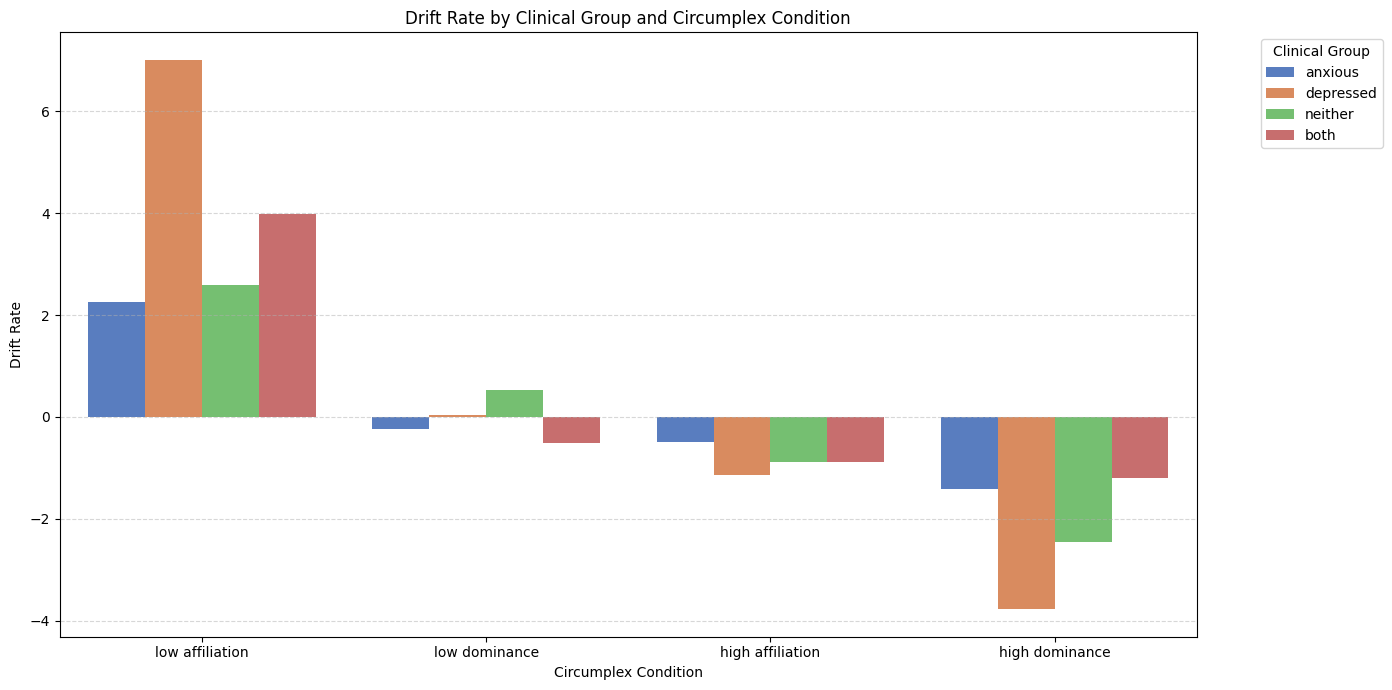

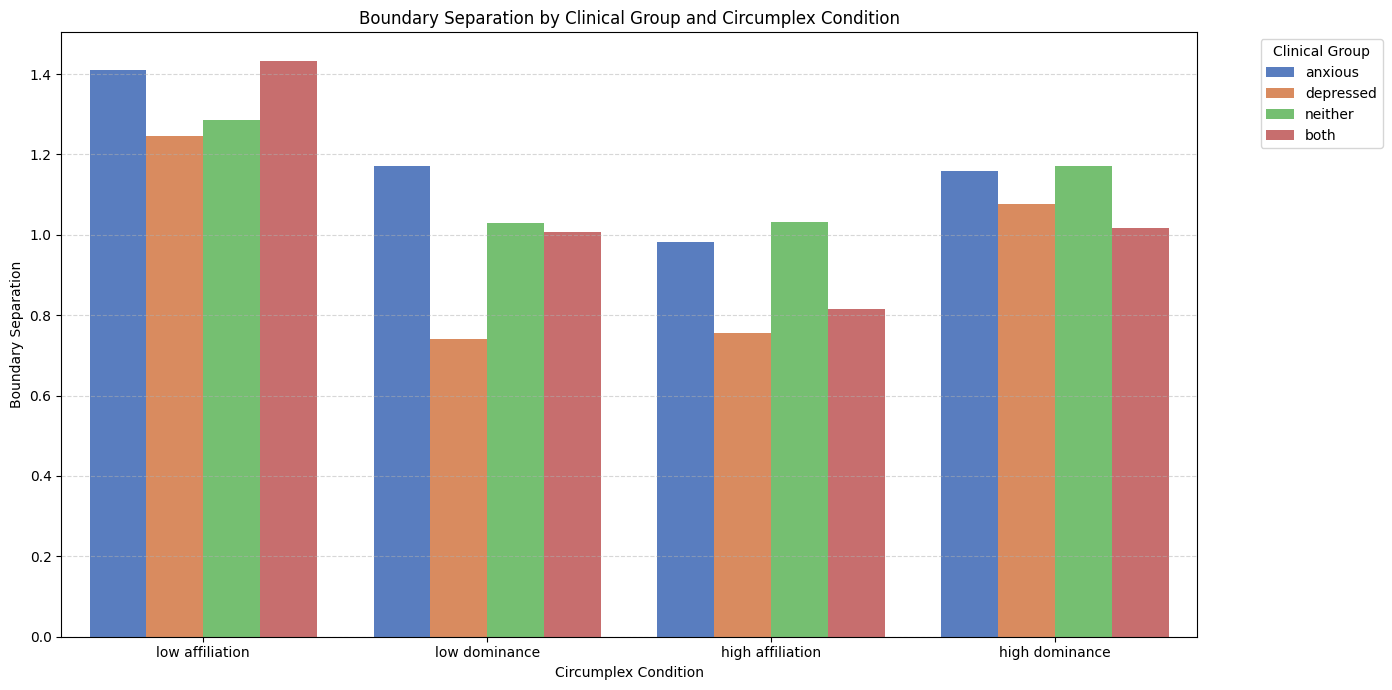

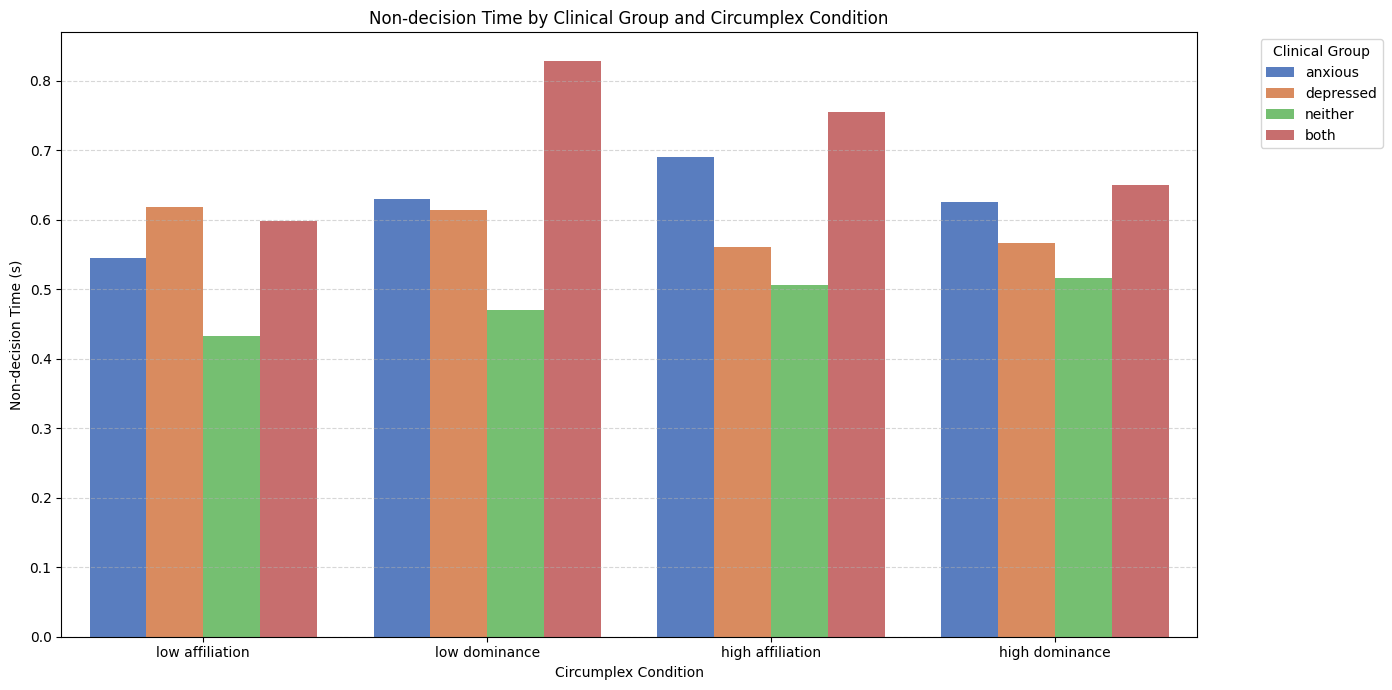

In [38]:
def plot_parameter(parameter, title, ylabel):
    plt.figure(figsize=(14, 7))

    # Reset index to ensure access to 'Clinical Group' and 'Circumplex Condition'
    df_plot = results_df.reset_index()

    # Define custom color palette
    color_palette = sns.color_palette("muted", n_colors=df_plot['Clinical Group'].nunique())

    # Plot the data
    sns.barplot(
        x="Circumplex Condition",
        y=parameter,
        hue="Clinical Group",
        data=df_plot,
        ci=None,
        palette=color_palette,
        dodge=True
    )

    # Set titles and labels
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel("Circumplex Condition")

    # Position the legend
    plt.legend(title="Clinical Group", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add grid lines to improve readability
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    # Optimize layout
    plt.tight_layout()
    plt.show()

# Plot each parameter without significance annotations
plot_parameter("Drift Rate", "Drift Rate by Clinical Group and Circumplex Condition", "Drift Rate")
plot_parameter("Boundary Separation", "Boundary Separation by Clinical Group and Circumplex Condition", "Boundary Separation")
plot_parameter("Non-decision Time", "Non-decision Time by Clinical Group and Circumplex Condition", "Non-decision Time (s)")
